# Generating Molecules with MoLGAN

In this tutorial, we will train a MolGAN network on the tox21 dataset which is a dataset of 12,060 training samples and 647 test samples of chemical compounds.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [2]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0   6983      0 --:--:-- --:--:-- --:--:--  6983


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing openmm, pdbfixer
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [3]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     |████████████████████████████████| 610 kB 4.3 MB/s 
     |████████████████████████████████| 20.6 MB 8.3 MB/s 


'2.6.0.dev'

In [4]:
!pip install --pre deepchem[tensorflow]

     |████████████████████████████████| 5.4 MB 3.8 MB/s 
     |████████████████████████████████| 454.4 MB 24 kB/s 
     |████████████████████████████████| 679 kB 60.3 MB/s 
     |████████████████████████████████| 1.2 MB 65.9 MB/s 
     |████████████████████████████████| 462 kB 26.5 MB/s 
     |████████████████████████████████| 4.0 MB 54.0 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68718 sha256=224d0ce141e485e8ac5f3ac90297a35f4b82788cc4ab03b2b4f5e3f94145e183
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
 

Import the packages you'll need.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import deepchem as dc
import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
import tensorflow as tf
from tensorflow import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

Download, load, and extract the SMILES strings from the tox21 dataset.

In [6]:
# Download from MolNet
# Try tox21 or LIPO dataset
tasks, datasets, transformers = dc.molnet.load_tox21()
df = pd.DataFrame(data={'smiles': datasets[0].ids})

In [8]:
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


Uncomment the first line if you want to subsample from the full dataset.

In [9]:
#data = df[['smiles']].sample(4000, random_state=42)
data = df

In [10]:
# create featurizer
feat = dc.feat.MolGanFeaturizer()

In [11]:
# featurize molecules
features = feat.featurize(data['smiles'].values)

Streaming output truncated to the last 5000 lines.
Failed to featurize datapoint 3621, Nc1ccc(Oc2ccc(N)c(N)c2)cc1. Appending empty array
Exception message: index 10 is out of bounds for axis 0 with size 9
Failed to featurize datapoint 3622, CSc1ccc(Oc2ccc(S(N)(=O)=O)cc2CN(C)C)cc1C. Appending empty array
Exception message: index 23 is out of bounds for axis 0 with size 9
Failed to featurize datapoint 3623, Brc1cc(Oc2cc(Br)c(Br)c(Br)c2Br)c(Br)c(Br)c1Br. Appending empty array
Exception message: index 20 is out of bounds for axis 0 with size 9
Failed to featurize datapoint 3624, BrCc1cccc(Oc2ccccc2)c1. Appending empty array
Exception message: index 11 is out of bounds for axis 0 with size 9
Failed to featurize datapoint 3625, N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)[O-]. Appending empty array
Exception message: index 21 is out of bounds for axis 0 with size 9
Failed to featurize datapoint 3626, O=[N+]([O-])c1ccc(Oc2ccc(C(F)(F)F)cc2[N+](=O)[O-])cc1. Appending empty array
Exception mes

In [12]:
len(features)

6264

In [13]:
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ]
print(indices)
features = [features[i] for i in indices]

[7, 8, 9, 10, 11, 15, 16, 17, 23, 25, 30, 32, 36, 37, 39, 44, 55, 56, 61, 69, 72, 73, 75, 81, 82, 86, 89, 91, 97, 98, 99, 101, 113, 114, 118, 119, 120, 121, 127, 130, 138, 143, 144, 145, 149, 150, 152, 153, 154, 155, 156, 159, 163, 165, 166, 168, 169, 180, 193, 196, 197, 198, 199, 201, 202, 203, 206, 213, 216, 222, 228, 229, 230, 236, 246, 261, 269, 270, 271, 272, 276, 278, 280, 284, 287, 288, 290, 293, 296, 297, 300, 302, 310, 319, 320, 328, 331, 332, 338, 341, 349, 350, 353, 354, 360, 365, 366, 367, 372, 374, 375, 376, 377, 380, 381, 383, 385, 399, 400, 401, 408, 412, 418, 423, 430, 431, 435, 438, 443, 449, 455, 460, 468, 469, 473, 481, 483, 486, 487, 488, 493, 494, 495, 501, 506, 507, 508, 513, 516, 522, 524, 526, 531, 532, 533, 536, 538, 542, 545, 546, 549, 550, 551, 554, 559, 560, 567, 568, 570, 585, 597, 598, 600, 602, 604, 605, 608, 610, 611, 613, 616, 624, 636, 638, 654, 656, 661, 666, 680, 682, 683, 689, 691, 692, 693, 695, 700, 701, 702, 710, 718, 721, 735, 741, 742, 743, 748

In [14]:
len(features)

751

In [15]:
# create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

In [16]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

In [17]:
gan.fit_gan(iterbatches(8), generator_steps=0.2, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(1000)

Ending global_step 63: generator average loss 5.15382, discriminator average loss 3.13241
TIMING: model fitting took 6.501 s
Generating 1000 samples


In [18]:
# convert graphs to RDKitmolecules
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


In [19]:
# remove invalid moles
nmols = list(filter(lambda x: x is not None, nmols))

In [20]:
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

425 valid molecules


In [35]:
img = Draw.MolsToGridImage(nmols[0:100], molsPerRow=5, subImgSize=(250, 250), maxMols=100, legends=None, useSVG=True)

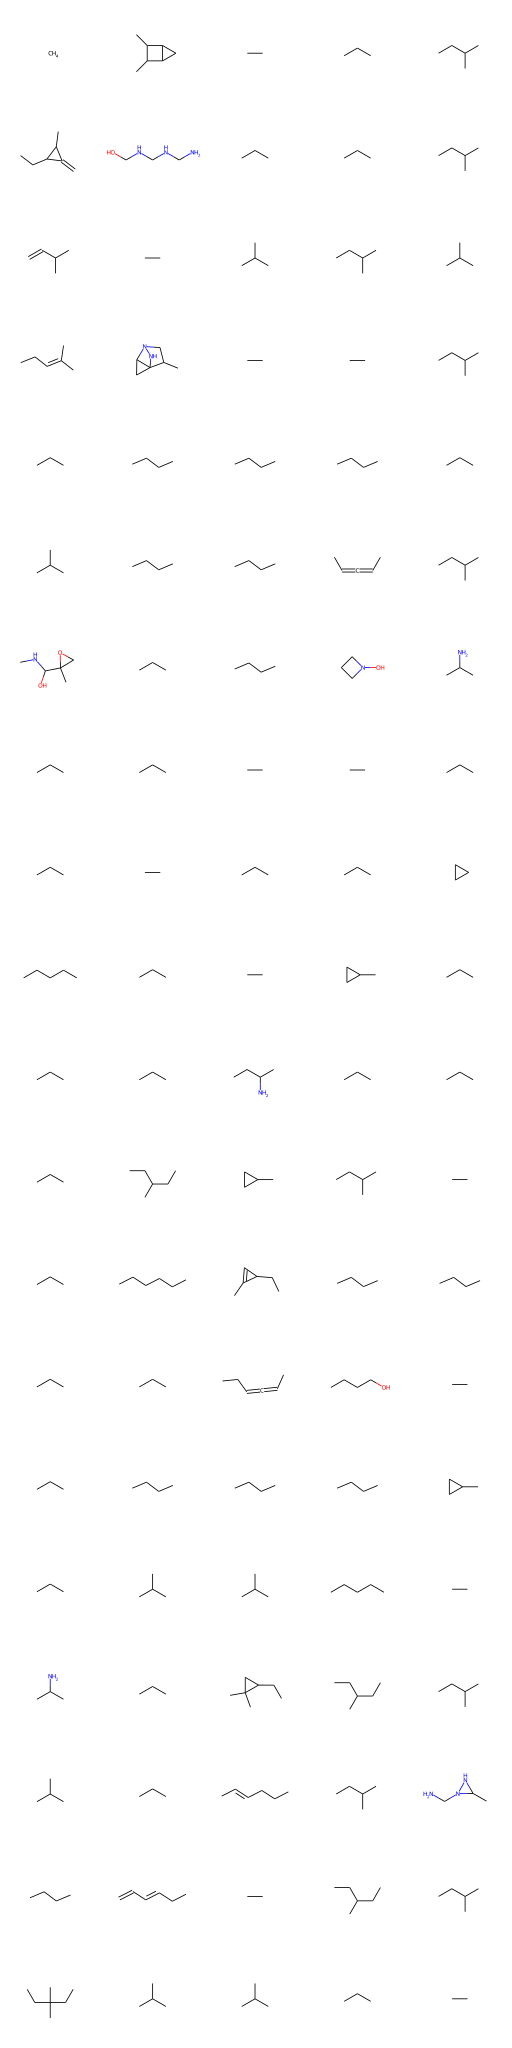

In [36]:
img